In [3]:
import os
from argparse import ArgumentParser, Namespace
from enum import Enum
from glob import glob
from typing import Dict, Iterable, Optional

import datasets as hf_datasets
from streaming import MDSWriter
from torch.utils.data import DataLoader, IterableDataset
from tqdm import tqdm
from transformers import AutoTokenizer, PreTrainedTokenizerBase

from llmfoundry.data import ConcatTokensDataset, NoConcatDataset
from tokenization_SEA_BPE import SEABPETokenizer
import multiprocessing
from typing import Iterator, Tuple

In [5]:
class ConcatMode(Enum):
    NO_CONCAT = 'NO_CONCAT'
    CONCAT_TOKENS = 'CONCAT_TOKENS'

In [34]:
def build_hf_dataset(
    path: str,
    split: str,
    mode: ConcatMode,
    max_length: Optional[int] = None,
    bos_text: str = '',
    eos_text: str = '',
    no_wrap: bool = False,
    tokenizer: PreTrainedTokenizerBase = None,
) -> IterableDataset:
    """Build an IterableDataset over the HF C4 or pile source data.

    Args:
        dataset_name (str): Dataset name
        split (str): Split name.
        mode (ConcatMode): NO_CONCAT, or CONCAT_TOKENS
        max_length (int): The length of concatenated tokens
        bos_text (str): text to insert at the beginning of each sequence
        eos_text (str): text to insert at the end of each sequence
        no_wrap (bool): if concatenating, whether to wrap text across `max_length` boundaries
        tokenizer (PreTrainedTokenizerBase): if mode is CONCAT_TOKENS, the tokenizer to use
        data_subset (str): Referred to as "name" in HuggingFace datasets.load_dataset.
            Typically "all" (The Pile) or "en" (c4).

    Returns:
        An IterableDataset.
    """

    hf_dataset = hf_datasets.load_dataset('json',
                                        data_files=path,
                                        split=split)

    dataset = ConcatTokensDataset(
        hf_dataset=hf_dataset,
        tokenizer=tokenizer,
        max_length=max_length,
        bos_text=bos_text,
        eos_text=eos_text,
        no_wrap=no_wrap,
    )

    return dataset



In [15]:
path = "/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/" 
out_root = "/home/project/11003280/data_Ngan/50B_for_Yuli/out5"
split = 'train'
concat_tokens = 2048
tokenizer = "aisingapore/sea-lion-7b"
bos_text = None
eos_text = '<|endoftext|>'
compression = 'zstd'
no_wrap = False

# num_processes=256
# chunk_size=200

In [31]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer, trust_remote_code=True)
tokenizer.model_max_length = int(1e30)

In [17]:
data_files = glob(f'{path}/*')
data_files

['/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/vi.jsonl',
 '/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/zh.jsonl',
 '/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/id.jsonl',
 '/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/en.jsonl',
 '/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/ms.jsonl',
 '/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/th.jsonl']

In [18]:
path = data_files[-2]
path

'/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/ms.jsonl'

In [19]:
path_name = path.split('/')[-1][:-5]
path_name

'ms.'

In [20]:
outpath = os.path.join(out_root, path_name)
print(path)
print(outpath)

/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/ms.jsonl
/home/project/11003280/data_Ngan/50B_for_Yuli/out5/ms.


In [23]:
print(bos_text)

None


In [33]:
dataset = build_hf_dataset(path=path,
                            split=split,
                            mode=ConcatMode,
                            max_length=concat_tokens,
                            eos_text=eos_text,
                            no_wrap=no_wrap,
                            tokenizer=tokenizer,
                            )

bos_text <class 'str'>
tokenizer <class 'transformers_modules.aisingapore.sea-lion-7b.2089235feeb2d990dfb62bb12bf32b85c5ccf780.tokenization_SEA_BPE.SEABPETokenizer'>


In [53]:
len(dataset)

TypeError: object of type 'ConcatTokensDataset' has no len()

In [36]:
first_item = next(iter(dataset))
print(first_item)


{'tokens': b'\x14\x02\x00\x00\x00\x00\x00\x00\x13\xd0\x00\x00\x00\x00\x00\x00/\x07\x00\x00\x00\x00\x00\x00Rt\x01\x00\x00\x00\x00\x00w9\x00\x00\x00\x00\x00\x00\x96"\x00\x00\x00\x00\x00\x00\xe0\x89\x02\x00\x00\x00\x00\x00\xd5\xcf\x03\x00\x00\x00\x00\x00\xf6\xcf\x03\x00\x00\x00\x00\x00\r\xd0\x03\x00\x00\x00\x00\x00Y*\x00\x00\x00\x00\x00\x00\xeb\xcf\x03\x00\x00\x00\x00\x00}V\x00\x00\x00\x00\x00\x00\xc7~\x01\x00\x00\x00\x00\x00\xb4\x03\x00\x00\x00\x00\x00\x00\xa00\x00\x00\x00\x00\x00\x00+\xae\x00\x00\x00\x00\x00\x00\x96"\x00\x00\x00\x00\x00\x00\xf6\x18\x00\x00\x00\x00\x00\x00\xc5]\x00\x00\x00\x00\x00\x00K\x01\x00\x00\x00\x00\x00\x00\xf0-\x00\x00\x00\x00\x00\x00\xfc\xf9\x01\x00\x00\x00\x00\x00\xefu\x00\x00\x00\x00\x00\x00j\x03\x00\x00\x00\x00\x00\x00K\x15\x00\x00\x00\x00\x00\x00\x08\x08\x00\x00\x00\x00\x00\x00\xeb\xcf\x03\x00\x00\x00\x00\x00\x07d\x00\x00\x00\x00\x00\x00e\x14\x00\x00\x00\x00\x00\x00\xa3x\x01\x00\x00\x00\x00\x00\xe2\x0b\x00\x00\x00\x00\x00\x00\x94\x01\x00\x00\x00\x00\x00\x00q\

In [38]:
print(len(first_item['tokens']))
print(type(first_item['tokens']))

16384
<class 'bytes'>


In [39]:
columns = {'tokens': 'bytes'}
outpath = '/home/project/11003280/data_Ngan/50B_for_Yuli/out4'

with MDSWriter(columns=columns,
                out=outpath,
                compression=compression,
                ) as out:
    # for sample in tqdm(dataset):
    for sample in dataset:
        out.write(sample)

KeyboardInterrupt: 

In [42]:
num_groups = 4
num_process = 2
out_root = outpath
print(out_root)

/home/project/11003280/data_Ngan/50B_for_Yuli/out4


In [44]:
!rm -r /home/project/11003280/data_Ngan/50B_for_Yuli/out4/*

rm: cannot remove '/home/project/11003280/data_Ngan/50B_for_Yuli/out4/*': No such file or directory


In [49]:
def each_task(out_root: str, groups: int) -> Iterator[Tuple[str, int, int]]:
    """Get the sub-directory path and the sample range for each sub-directory.

    Args:
        out_root (str): base output mds directory
        groups (int): Number of sub-directories to create

    Yields:
        Iterator[Tuple[str, int, int]]: Each argument tuple
    """
    for data_group in range(groups):
        sub_out_root = os.path.join(out_root, str(data_group))
        start_sample_idx = data_group * 10
        end_sample_idx = start_sample_idx + 9
        yield sub_out_root, start_sample_idx, end_sample_idx

arg_tuples = each_task(out_root, groups=num_groups)
print(next(iter(arg_tuples)))

('/home/project/11003280/data_Ngan/50B_for_Yuli/out4/0', 0, 9)


In [50]:
print(next(iter(arg_tuples)))

('/home/project/11003280/data_Ngan/50B_for_Yuli/out4/1', 10, 19)


In [46]:
def convert_to_mds(args: Iterator[Tuple[str, int, int]]) -> None:
    """Convert raw dataset into MDS format

    Args:
        args (Iterator[Tuple[str, int, int]]): All arguments, packed into a tuple because
            process pools only pass one argument.

    Yields:
        Dict: A sample
    """
    sub_out_root, start_sample_idx, end_sample_idx = args

    #TODO, needs rewrite here, to yield a segment of dataset
    def get_data(start: int, end: int):
        for i in range(start, end + 1):
            yield {'number': i}

    #define the column names
    columns = {'tokens': 'bytes'}

    with MDSWriter(out=sub_out_root,
                   columns=columns) as out:
        # start_sample_idx: 10
        # end_sample_idx: 19
        # dummy sample: [{nubmer:10}, {number:11}, ..., {number:19}]
        # actual sample: 
        for sample in get_data(start_sample_idx, end_sample_idx):
            out.write(sample)

In [51]:
# Initialize the worker process
def init_worker():
    # Get the pid for the current worker process
    pid = os.getpid()
    print(f'\nInitialize Worker PID: {pid}', flush=True, end='')



In [ ]:
# Process group of data in parallel into directories of shards.
with multiprocessing.Pool(initializer=init_worker, processes=num_process) as pool:
    for count in pool.imap(convert_to_mds, arg_tuples):
        pass
print('Finished')

## Mosaic Sample Code from pile.py 
- parallel by dataset

In [2]:
import json
import os
from argparse import ArgumentParser, Namespace
from collections import Counter
from glob import glob
from multiprocessing import Pool
from typing import Dict, Iterator, List, Tuple

from streaming.base import MDSWriter
from streaming.base.util import get_list_arg


/home/project/11003280/envs/mosaic_yuli/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Copyright 2022-2024 MosaicML Streaming authors
# SPDX-License-Identifier: Apache-2.0

"""Pile streaming dataset conversion script."""

import json
import os
from argparse import ArgumentParser, Namespace
from collections import Counter
from glob import glob
from multiprocessing import Pool
from typing import Dict, Iterator, List, Tuple

from streaming.base import MDSWriter
from streaming.base.util import get_list_arg


# def parse_args() -> Namespace:
#     """Parse command-line arguments.

#     Args:
#         Namespace: command-line arguments.
#     """
#     args = ArgumentParser()
#     args.add_argument(
#         '--in_root',
#         type=str,
#         required=True,
#         help='Local directory path of the input raw dataset',
#     )
#     args.add_argument(
#         '--out_root',
#         type=str,
#         required=True,
#         help='Directory path to store the output dataset',
#     )
#     args.add_argument(
#         '--compression',
#         type=str,
#         default='zstd:16',
#         help='Compression algorithm to use. Empirically, Zstandard has the best performance in ' +
#         'our benchmarks. Tune the compression level (from 1 to 22) to trade off time for ' +
#         'quality. Defaults to zstd:16',
#     )
#     args.add_argument(
#         '--hashes',
#         type=str,
#         default='sha1,xxh64',
#         help='Hashing algorithms to apply to shard files. Default: sha1,xxh64',
#     )
#     args.add_argument(
#         '--size_limit',
#         type=int,
#         default=1 << 27,
#         help='Shard size limit, after which point to start a new shard. Default: 1 << 27',
#     )
#     return args.parse_args()


def each_task(in_root: str, out_root: str, compression: str, hashes: List[str], size_limit: int,
              in_files: List[str]) -> Iterator[Tuple[str, str, str, List[str], int]]:
    """Get the arg tuple corresponding to each JSONL input file to convert to streaming.

    Args:
        in_root (str): Root directory of input JSONL files.
        out_root (str): Root directory of output MDS files.
        compression (str): Which compression algorithm to use, or empty if none.
        hashes (List[str]): Hashing algorithms to apply to shard files.
        size_limit (int): Shard size limit, after which point to start a new shard.
        in_files (List[str]): List of input files to generate arguments for.

    Returns:
        Iterator[Tuple[str, str, str, List[str], int]]: Each argument tuple.
    """
    for in_file in in_files:
        assert in_file.startswith(in_root)
        assert in_file.endswith('.jsonl')
        out_dir = os.path.join(out_root, in_file[len(in_root):-len('.jsonl')].lstrip('/'))
        yield in_file, out_dir, compression, hashes, size_limit


def file_to_dir(args: Tuple[str, str, str, List[str], int]) -> Dict[str, int]:
    """Convert a JSONL input file into a directory of MDS shards.

    This is the unit of work executed by the process pool.

    Args:
        args (Tuple[str, str, str, List[str], int]): All arguments, packed into a tuple because
            process pools only pass one argument.

    Raises:
        ValueError: Invalid sample fields.
        ValueError: Invalid sample meta fields.

    Returns:
        Dict[str, int]: Count of how many samples belonged to each Pile dataset subset.
    """
    in_file, out_dir, compression, hashes, size_limit = args

    columns = {
        'text': 'str',
        'pile_set_name': 'str',
    }

    counts = Counter()
    with MDSWriter(out=out_dir,
                   columns=columns,
                   compression=compression,
                   hashes=hashes,
                   size_limit=size_limit,
                   progress_bar=True) as out:
        for line in open(in_file):
            obj = json.loads(line)
            if sorted(obj.keys()) != ['meta', 'text']:
                raise ValueError('Invalid sample fields.')
            text = obj['text']
            meta = obj['meta']
            if sorted(meta.keys()) != ['pile_set_name']:
                raise ValueError('Invalid sample meta fields.')
            pile_set_name = meta['pile_set_name']
            sample = {
                'text': text,
                'pile_set_name': pile_set_name,
            }
            out.write(sample)
            counts[pile_set_name] += 1
    return counts


def with_id(basename: str, shard_id: int) -> str:
    """Get a new basename with the given shard_id.

    Args:
        basename (str): Old basename of file.
        shard_id (int): New shard ID.

    Returns:
        str: New basename of file.
    """
    parts = basename.split('.')
    parts[1] = f'{shard_id:05}'
    return '.'.join(parts)


def merge_shard_groups(root: str) -> None:
    """Merge ephemeral sub-datasets created in parallel into one dataset.

    Args:
        root (str): Root directory.
    """
    # root = /home/project/11003280/data_Ngan/50B_for_Yuli/out4
    # pattern = /home/project/11003280/data_Ngan/50B_for_Yuli/out4/*
    pattern = os.path.join(root, '*')
    # sudirs = [/home/project/11003280/data_Ngan/50B_for_Yuli/out4/0., ...]
    subdirs = sorted(glob(pattern))
    shard_id = 0
    infos = []
    for subdir in subdirs:
        # subdir = /home/project/11003280/data_Ngan/50B_for_Yuli/out4/0./index.json
        index_filename = os.path.join(subdir, 'index.json')
        obj = json.load(open(index_filename))

        # e.g. info =
        # {
        #     "column_encodings": [
        #         "bytes"
        #     ],
        #     "column_names": [
        #         "tokens"
        #     ],
        #     "column_sizes": [
        #         null
        #     ],
        #     "compression": "zstd",
        #     "format": "mds",
        #     "hashes": [],
        #     "raw_data": {
        #         "basename": "shard.00095.mds",
        #         "bytes": 57011559,
        #         "hashes": {}
        #     },
        #     "samples": 3478,
        #     "size_limit": 67108864,
        #     "version": 2,
        #     "zip_data": {
        #         "basename": "shard.00095.mds.zstd",
        #         "bytes": 12780022,
        #         "hashes": {}
        #     }
        # }


        for info in obj['shards']:
            # update the local shard id to global shard id for non-compressed data in 'mds' format
            # old_basename = shard.00095.mds
            old_basename = info['raw_data']['basename']
            # new_basename = shard.00176.mds, the shard_id is now the global shard id
            new_basename = with_id(old_basename, shard_id)
            info['raw_data']['basename'] = new_basename

            # repeat the same for the compressed data in 'zstd' format
            old_basename = info['zip_data']['basename']
            new_basename = with_id(old_basename, shard_id)
            info['zip_data']['basename'] = new_basename

            # NOTE: implicitly check if compressed file is used, if so, moves the compressed files only
            # old_filename = /home/project/11003280/data_Ngan/50B_for_Yuli/out4/0./shard.00095.mds.zstd
            old_filename = os.path.join(subdir, old_basename)
            # new_filename = /home/project/11003280/data_Ngan/50B_for_Yuli/out4/shard.00176.mds.zstd
            new_filename = os.path.join(root, new_basename)

            # move and rename the mds/zstd files, report error if any
            assert not os.rename(old_filename, new_filename)

            # increment global shard_id
            shard_id += 1

            # incrementally build the content of global index.json
            infos.append(info)

        # remove the original index file inside each subdir, report error if any
        assert not os.remove(index_filename)
        # remove the original subdir, report error if any
        assert not os.rmdir(subdir)

    # create new index file inside the main dir, with the global content collected from infos
    index_filename = os.path.join(root, 'index.json')
    obj = {
        'version': 2,
        'shards': infos,
    }
    text = json.dumps(obj, sort_keys=True)
    with open(index_filename, 'w') as out:
        out.write(text)


# def main(args: Namespace) -> None:
#     """Convert the Pile to streaming format.

#     Args:
#         args (Namespace): Command-line arguments.
#     """
#     hashes = get_list_arg(args.hashes)

#     # Find the original JSONL files to convert.
#     pattern = os.path.join(args.in_root, 'train', '*.jsonl')
#     trains = sorted(glob(pattern))
#     val = os.path.join(args.in_root, 'val.jsonl')
#     test = os.path.join(args.in_root, 'test.jsonl')
#     in_files = trains + [val, test]

#     # Get the arguments for each JSONL file conversion.
#     arg_tuples = each_task(args.in_root, args.out_root, args.compression, hashes, args.size_limit,
#                            in_files)

#     # Process each JSONL file in parallel into directories of shards.
#     with Pool() as pool:
#         counters = pool.imap(file_to_dir, arg_tuples)
#         for in_file, counts in zip(in_files, counters):
#             obj = {
#                 'file': in_file,
#                 'counts': counts,
#             }
#             print(json.dumps(obj, sort_keys=True))

#     # Merge shard groups.
#     train_root = os.path.join(args.out_root, 'train')
#     merge_shard_groups(train_root)


# if __name__ == '__main__':
#     main(parse_args())

In [3]:
ARGhashes = 'sha1,xxh64'

hashes = get_list_arg(ARGhashes)

In [10]:
hashes

['sha1', 'xxh64']

In [16]:
in_root = "/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/" 
out_root = "/home/project/11003280/data_Ngan/50B_for_Yuli/out5"
# split = 'train'
# concat_tokens = 2048
# tokenizer = "aisingapore/sea-lion-7b"
# bos_text = None
# eos_text = '<|endoftext|>'
compression = 'zstd'
# no_wrap = False

size_limit = 1 << 27

In [8]:

    pattern = os.path.join(in_root, '*.jsonl')
    trains = sorted(glob(pattern))
    in_files = trains

In [9]:
in_files

['/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/en.jsonl',
 '/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/id.jsonl',
 '/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/ms.jsonl',
 '/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/th.jsonl',
 '/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/vi.jsonl',
 '/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/zh.jsonl']

In [18]:
arg_tuples = each_task(in_root, out_root, compression, hashes, size_limit, in_files)


In [21]:
next(iter(arg_tuples))

('/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/en.jsonl',
 '/home/project/11003280/data_Ngan/50B_for_Yuli/out5/en',
 'zstd',
 ['sha1', 'xxh64'],
 134217728)

In [22]:
next(iter(arg_tuples))

('/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/id.jsonl',
 '/home/project/11003280/data_Ngan/50B_for_Yuli/out5/id',
 'zstd',
 ['sha1', 'xxh64'],
 134217728)

In [23]:

# Process each JSONL file in parallel into directories of shards.
with Pool() as pool:
    counters = pool.imap(file_to_dir, arg_tuples)
    for in_file, counts in zip(in_files, counters):
        obj = {
            'file': in_file,
            'counts': counts,
        }
        print(json.dumps(obj, sort_keys=True))



ValueError: Invalid sample fields.

In [ ]:
    # Merge shard groups.
    train_root = os.path.join(args.out_root, 'train')
    merge_shard_groups(train_root)

# Preprocessing jsonl

In [ ]:
source_path = '/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/en.jsonl'

In [24]:
!wc -l /home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/combined.jsonl


^C


In [27]:
import json

input_path = "/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/combined.jsonl"
with open(input_path, "r") as file:
    # Read the first 2 lines (items) from the file
    text_lengths = []
    for i in range(190000, 193318):
        line = file.readline()
        # Load the JSON object
        item = json.loads(line)
        # Print the item
        length = len(item['text'])
        if length <= 1:
            print(f"line{i} has text {item['text']}")
        text_lengths.append(length)
        

    avg_length = sum(text_lengths)/len(text_lengths)
    print(avg_length)




380953.16968053044


In [1]:
import math
import time
import os

def avg_text_length_local(buffer_header: list) -> float:
    if not buffer_header:
        # Return a small value if the input list is empty to prevent 0-division error
        return 1e-6  

    text_lengths = []
    for line in buffer_header:
        # Load the JSON object
        item = json.loads(line)
        # Print the item
        text_lengths.append(len(item['text']))

    avg_length = sum(text_lengths)/len(text_lengths)
    return(avg_length)

def split_jsonl(input_path: str, split_dir: str, lines_per_file:int):
    start_time = time.time()  # Start measuring time
    print('begin to split source jsonl')

    if not os.path.exists(split_dir):
        os.makedirs(split_dir)
   
    file_number = 0
    buffer = []
    # default text length per sample is 2000
    std_text_length = 2e3
    sample_size = 10

    with open(input_path, 'r') as source_file:
       
        while True:      
            # Read a block of lines            
            buffer_header = [source_file.readline() for _ in range(sample_size)]
            text_length_ratio = std_text_length/avg_text_length_local(buffer_header) # [2, 1, 0.1,..., 0.0001 ]
            reduction_rate = max(-math.log(text_length_ratio), 1.0) # [1.0, 1.0, 2.0, ..., 6.0]
            true_lines_per_file = int(lines_per_file / reduction_rate)
            print(f'split {file_number} reduced by {reduction_rate:.2}X >> lines/file {true_lines_per_file}')

            print(f'buffer will collect lines from {len(buffer_header)} and {true_lines_per_file-sample_size}')
            try:
                buffer = buffer_header + [source_file.readline() for _ in range(true_lines_per_file-sample_size)]
            except Exception as e:
                print(e)

            print(f"Buffer now has {len(buffer)} lines; expected was {true_lines_per_file}.")
            if not buffer[-1]:
                print("Last line read is empty, potential EOF reached prematurely.")
            
            # Check if the end of the file has been reached
            if not buffer[0]:
                print(f'file reading completed, break')
                break
            # Remove any empty strings that signify end of file in the last read block
            buffer = list(filter(None, buffer))
        
            # # Write to file
            # using single processing
            with open(os.path.join(split_dir, f'{file_number}.jsonl'), 'w') as output_file:
                print(f'begin writing {file_number}.jsonl')
                output_file.writelines(buffer)
                print(f'finish writing {file_number}.jsonl')
        
            file_number += 1
    duration = time.time() - start_time
    print(f'source jsonl split completed in {duration:.1f} seconds')


input_path = '/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/combined.jsonl'
split_dir = '/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/split'
split_jsonl(input_path, split_dir, 1e6)

begin to split source jsonl


NameError: name 'json' is not defined

In [ ]:
# def avg_text_length(buffer_header: list):

#         text_lengths = []
#         for _ in range(10):
#             line = file.readline()
#             # Load the JSON object
#             item = json.loads(line)
#             # Print the item
#             text_lengths.append(len(item['text']))

#         avg_length = sum(text_lengths)/len(text_lengths)
#         return(avg_length)

jsonl line size (32,774,429 in total):
- ms: 729776
- zh: 10271229
- vi: 8415996
- id: 1058057
- th: 9329291
- en: 2970080

jsonl file size (311 G total)
- ms: 1.6G
- zh: 60G
- vi: 27G
- id: 2.2G
- th: 99G
- en: 121G


In [17]:
print('ms lines/G', int(729776 / 1.6))

print('id lines/G', int(1058057 / 2.2))

print('id lines/G', int(8415996 / 27))

print('zh lines/G', int(10271229 / 60))

print('th lines/G', int(9329291/ 99))

print('en lines/G', int(2970080 / 121))

print('total lines estimate:', 300000*311)

nCPU= 48
print('each CPU to handle # lines:', 300000*311/nCPU) # ~ 2million lines per CPU (or per child jsonl)

ms lines/G 456110
id lines/G 480934
id lines/G 311703
zh lines/G 171187
th lines/G 94235
en lines/G 24546
total lines estimate: 93300000
each CPU to handle # lines: 1943750.0


In [12]:
def avg_text_length(input_path: str):
    with open(input_path, "r") as file:
        # Read the first 2 lines (items) from the file
        text_lengths = []
        for _ in range(10):
            line = file.readline()
            # Load the JSON object
            item = json.loads(line)
            # Print the item
            text_lengths.append(len(item['text']))

        avg_length = sum(text_lengths)/len(text_lengths)
        return(avg_length)


import json

# Open the JSONL file
with open('/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/split/0.jsonl', "r") as file:
    # Read the first 2 lines (items) from the file
    text_lengths = []
    for _ in range(10):
        line = file.readline()
        # Load the JSON object
        item = json.loads(line)
        # Print the item
        text_lengths.append(len(item['text']))

    avg_length = sum(text_lengths)/len(text_lengths)
    print(avg_length)


avg_text_length('/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/split/0.jsonl')


386173.0


386173.0

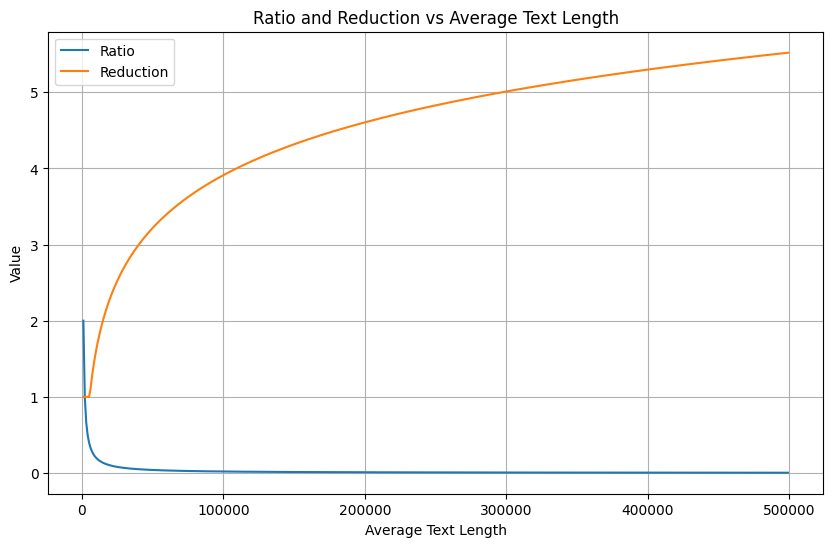

In [23]:
import math
import matplotlib.pyplot as plt

std_text_length = 2e3

avg_text_lengths = range(1000, 500000, 1000)
ratios = []
reductions = []

for avg_text_length in avg_text_lengths:
    ratio = std_text_length / avg_text_length # [0.0001, 0.001, 0.01, 0.1, 1, 1, 1]
    reduction = max(-math.log(ratio), 1.0)
    ratios.append(ratio)
    reductions.append(reduction)

plt.figure(figsize=(10, 6))

plt.plot(avg_text_lengths, ratios, label='Ratio')
plt.plot(avg_text_lengths, reductions, label='Reduction')
plt.xlabel('Average Text Length')
plt.ylabel('Value')
plt.title('Ratio and Reduction vs Average Text Length')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import json
from concurrent.futures import ProcessPoolExecutor

def process_chunk(start_line, num_lines, infile, outfile):
    with open(infile, 'r') as file:
        # Skip to the start line
        for _ in range(start_line):
            next(file)
        
        # Write the specified number of lines to the output file
        with open(outfile, 'w') as out:
            for _ in range(num_lines):
                line = next(file, None)
                if line is None:
                    break
                out.write(line)

def split_jsonl(file_path, lines_per_file, num_splits):
    # Calculate total lines if not known: 
    # with open(file_path, 'r') as file:
    #     total_lines = sum(1 for line in file)

    total_lines = 50000000  # Example total line count
    executor = ProcessPoolExecutor(max_workers=30)

    futures = []
    for i in range(num_splits):
        start_line = i * lines_per_file
        outfile = f"output_{i}.jsonl"
        # Schedule the tasks
        future = executor.submit(process_chunk, start_line, lines_per_file, file_path, outfile)
        futures.append(future)

    # Wait for all futures to complete
    for future in futures:
        future.result()

split_jsonl('large_file.jsonl', 2000000, 25)  # Adjust parameters as needed


In [13]:
#!/bin/bash

# Define variables
SOURCE_FILE="/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/en.jsonl"
OUTPUT_DIR="/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/yuli_split"
LINES_PER_FILE=2000000
PREFIX="en"

# Create output directory if it does not exist
!mkdir -p $OUTPUT_DIR

# Use the split command
# -d: use numeric suffixes starting at 0
# -l: number of lines per output file
# --additional-suffix: append .jsonl to the output files
!split -d -l $LINES_PER_FILE --additional-suffix=.jsonl $SOURCE_FILE $OUTPUT_DIR/$PREFIX

!echo "Splitting completed. Files are stored in $OUTPUT_DIR"


^C
Splitting completed. Files are stored in /home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/yuli_split


In [ ]:
import dask.bag as db
import json
import os
from dask.distributed import Client

def split_jsonl(input_file_path, output_dir, num_partitions=48):
    # Setup Dask client to use multiple workers
    client = Client()  # Adjust this based on your hardware
    print(client)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Create a Dask Bag from the input JSONL file
    b = db.read_text(input_file_path).map(json.loads)
    
    # # Calculate the number of partitions
    # total_lines = sum(1 for _ in open(input_file_path))
    b = b.repartition(npartitions=num_partitions)
    
    # Save each partition to a separate JSONL file
    for i, partition in enumerate(b.to_delayed()):
        filename = os.path.join(output_dir, f'en{i}.jsonl')
        # Trigger computation and save to file
        partition.compute().to_json(filename, orient='records', lines=True)

    client.close()  # Properly shutdown the Dask client

# Example call to the function

input_path="/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/en.jsonl"
output_dir="/home/project/11003280/data_Ngan/50B_for_Yuli/yuli_data/yuli_split"
split_jsonl(input_path, output_dir)


In [18]:
!pip install "dask[complete]"

In [ ]:
cat *.jsonl > combined.jsonl


In [2]:
tokentype = "aisingapore/sea-lion-7b"
from transformers import AutoTokenizer, PreTrainedTokenizerBase

tokenizer = AutoTokenizer.from_pretrained(tokentype, trust_remote_code=True)


/home/project/11003280/envs/mosaic_yuli/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
